We are going to implement a code for Linear Quadratic Control problem 

Loss function = $\dfrac1M\sum_{t=0}^{N-1}((aX_t^2+bX_t+Au_t^2+Bu_t)\delta_t+\alpha X_T^2+\beta X_T)$

where $\delta_t=\frac{N}{T}$

State Process $X_{t+1}=X_t+(cX_t+du_t)\delta_t+\sigma\delta_t\epsilon_t$

The HJB equation is given by

$0=\partial_t V(t,x)+\frac{\sigma^2}{2}\partial_x^2V(t,x) +cx\partial_xV(t,x)+ax^2+bx+\inf_u\Big[Au^2+\Big(B+d\partial_xV(t,x)\Big)u\Big]$

$V(T,x)=\alpha x^2+\beta x$.

The optimal solution solution obtained as
$u^*=-\frac{B+d\partial_xV(t,x)}{2A}$
depends on the value function $V(t,x)$, which is the solution of the following PDE
$0=\partial_t V(t,x)+\frac{\sigma^2}{2}\partial_x^2V(t,x) +cx\partial_xV(t,x)+ax^2+bx-\frac{\big(B+d\partial_xV(t,x)\big)^2}{4A}$

$V(T,x)=\alpha x^2+\beta x$.

We assume that the value function is quadratic in $x$,

$V(t,x)=f(t)x^2+h(t)x+k(t)$. 

By substituting $V$ in the HJB PDE we get the following system of Riccati ODE.

$0=f'+a+2cf-\frac{d^2}{A}f^2;  f(T)=\alpha$

$0=h'+b-\frac{(B+dh)d}{A}f;  h(T)=\beta$

$0=k'+\sigma^2 f-\frac{1}{4A}(B+dh)^2;  k(T)=0$

By solving this system of first order ODE we can get $f,h,t$ in closed form and we obtain the optimal solution as

$u^*=-\frac{B+d(2xf(t)+h(t))}{2A}$

In [67]:
import numpy as np
import time
from scipy import misc
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

import json

In [68]:
M=100
ite=10
T=1
delta = torch.tensor(T/ite)
a=0.1
b=0.1
c=0.1
d=0.1
A=0.1
B=0.1
sigma=0.01
alpa=0.1
beta=0.1
neuron_model_psi=50
dim_n=2
print(delta)

tensor(0.1000)


In [69]:
# model= torch.nn.Sequential(
#     torch.nn.Linear(dim_n, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
# #     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
# #     torch.nn.ReLU(),
# #     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
# #     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi,1)
# )

In [70]:
model= torch.load('model_N100_LQC_uniform_0_1_alpa_0.1.pth')


In [71]:
t=torch.zeros([M,1])
up_lim=1
#z=np.zeros([M,ite+1])+np.random.rand(M,1)
# z=torch.FloatTensor(M,ite+1).uniform_(0,0.01)
z=0.01*torch.normal(0, 1, size=(M, ite+1))
x_train=torch.FloatTensor(M,1).uniform_(0,up_lim)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
# x_train=torch.normal(0, 1, size=(M, 1))
data=torch.cat((t,x_train),dim=1)
# print(data.dtype)
# print(z.dtype)
# print(z[:,2].shape)
#print(x)

In [72]:
def update(x3,psi,z,i):
    t=(x3[:,0]+(T/ite))
    #print(x3[:,1].shape,z[:,i].shape,psi.shape)
    x=x3[:,1]+(c*x3[:,1]+d*psi)*delta+sigma*torch.sqrt(delta)*z[:,i]
    up=torch.cat((t.unsqueeze(1),x.unsqueeze(1)),dim=1)
#     print('up shape=', up.shape)
    return up

def loss_func(x2,psi):
    loss=a*torch.pow(x2[:,1],2)+b*x2[:,1]+A*torch.pow(psi,2)+B*psi
    return loss

def loss_func_ter(x4):
    loss=alpa*torch.pow(x4[:,1],2)+beta*x4[:,1]
    return loss

def unit(x1,model,i):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi,z,i)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(u,model,epoch):
    loss=torch.zeros(M,ite)
    psi=torch.zeros(M,ite)
    state_var=[]
    if (epoch==max_epoch-1):
        state_var.append(u.detach().numpy())   
    for i in range(ite+1):
        if(i<ite):
            psi_run,loss_run,u_run=unit(u,model,i)
            #print('los func=',psi_run.shape,loss_run.shape)
            loss[:,i]=loss_run
            #print(loss)
            psi[:,i]=psi_run
            #print(psi)
            u=u_run
            if (epoch==max_epoch-1):
                state_var.append(u.detach().numpy())             
            #print(u)
        else:
            loss_ter=loss_func_ter(u)
          #print('ter',loss_ter.shape)
        #print(torch.sum(loss,dim=1))
    loss=torch.sum(loss,dim=1)*delta+loss_ter
    #print(loss.shape)
    return torch.mean(loss),state_var


In [ ]:
start=time.time()
lr1 = 8e-3
max_epoch = 1500
cost_ar=[]
optimizer = optim.Adam(model.parameters(), lr1)

#print(psi.shape)
for epoch in range(max_epoch):
    optimizer.zero_grad()
    cost,state_var_train=loss_func_total(data,model,epoch)
    cost.backward()
    optimizer.step()
    cost_ar.append(cost)
    #print(loss.item())
    if (epoch % 100==0):
        print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
end=time.time()
total_time=end-start
print('Training time=',total_time)


At epoch 0 the` mean cost is 0.14117273688316345.
At epoch 100 the` mean cost is 0.14116458594799042.
At epoch 200 the` mean cost is 0.14116448163986206.
At epoch 300 the` mean cost is 0.14116445183753967.
At epoch 400 the` mean cost is 0.14116442203521729.
At epoch 500 the` mean cost is 0.1411644071340561.
At epoch 600 the` mean cost is 0.1411643922328949.
At epoch 700 the` mean cost is 0.1411643922328949.
At epoch 800 the` mean cost is 0.1411643773317337.
At epoch 900 the` mean cost is 0.1411643773317337.
At epoch 1000 the` mean cost is 0.1411643624305725.
At epoch 1100 the` mean cost is 0.1411643624305725.
At epoch 1200 the` mean cost is 0.14116434752941132.
At epoch 1300 the` mean cost is 0.14116434752941132.
At epoch 1400 the` mean cost is 0.14116434752941132.
Training time= 6.276320934295654


In [91]:
M1=10
x_ar=[]
#z1=torch.randn(size=(M1,ite))
# z1=torch.FloatTensor(M1,ite+1).uniform_(0,0.01)
z1=0.01*torch.normal(0, 1, size=(M1, ite+1))
t_test=torch.zeros([M1,1])
x1=torch.linspace(0.1*up_lim,0.95*up_lim, steps=M1).unsqueeze(1)
x_test=torch.cat((t_test,x1),dim=1)
print(x_test)
pred_soln=torch.zeros(M1,ite+1)
for i in range(ite+1):
    x_ar.append(x_test[:,1].numpy())
    soln_pred=model(x_test).squeeze(1).detach()
    pred_soln[:,i]=soln_pred
    x_test=update(x_test,soln_pred,z1,i)
#x_ar.append(x_test[:,1].numpy())
state_var=np.squeeze(np.array(x_ar))
state_var=state_var.transpose()
print(state_var.shape,pred_soln.shape)

tensor([[0.0000, 0.1000],
        [0.0000, 0.1944],
        [0.0000, 0.2889],
        [0.0000, 0.3833],
        [0.0000, 0.4778],
        [0.0000, 0.5722],
        [0.0000, 0.6667],
        [0.0000, 0.7611],
        [0.0000, 0.8556],
        [0.0000, 0.9500]])
(10, 11) torch.Size([10, 11])


# Closed Form Solution

In [92]:
import scipy.integrate as integrate
q0=A
q1=2*c
q2 = -d**2/A
lb1=0.5*(q1+np.sqrt(q1**2-4*q0*q2))
lb2 = -lb1+q1
C1 = -(lb1+q2*alpa)/(lb2+q2*alpa)
C2 = (beta+B/d)*(1+C1)/b-(1/lb1+C1/lb2)
f_func = lambda t: -1/q2*(lb1*np.exp(lb1*(T-t))+C1*lb2*np.exp(lb2*(T-t)))/(np.exp(lb1*(T-t))+C1*np.exp(lb2*(T-t)))
h_func = lambda t: b*((1/lb1)*np.exp(lb1*(T-t))+C1*(1/lb2)*np.exp(lb2*(T-t))+C2)/(np.exp(lb1*(T-t))+C1*np.exp(lb2*(T-t)))-B/d

integrand = lambda t: sigma**2*f_func(t) -(B+d*h_func(t))**2/(4*A)
k_func = lambda t: integrate.quad(lambda x: integrand(x), 0, T-t)
k_func(0.2)

(-0.02645582430159435, 2.9371865275067797e-16)

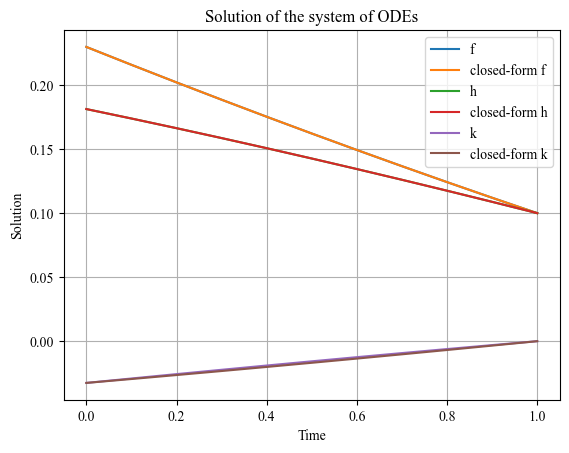

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
(11,) (10, 11)


In [93]:
# Define the system of ODEs
def system_of_odes(t, y):
    dydt = [
        a+2*c*y[0]-(np.power(d,2)*np.power(y[0],2))/A,                 # df/dt = a+2cf-d^2*f^2/A; f(0)=alpa
        b-(B+d*y[1])*d*y[0]/A,                       # dh/dt = b-(B+dh)fd/A; h(0)=beta
        np.power(sigma,2)*y[0]-(B+d*y[1])**2/(4*A)        # dk/dt = sigma^2*f-(B+dh)^2/4A; k(0)=0
    ]
    return dydt

# Initial conditions
initial_conditions = [alpa, beta, 0]  # Initial values for y1, y2, and y3

# Time span
t_span = (0, T)  # Start and end time
t_eval=np.linspace(0, 1, ite+1)
# Solve the system of ODEs
sol = solve_ivp(system_of_odes,t_span, initial_conditions, t_eval=np.linspace(0, 1, ite+1))
#
f=np.flip(sol.y[0])
h=np.flip(sol.y[1])
k=np.flip(sol.y[2])
# Plot the solution
plt.plot(sol.t, f, label='f')
plt.plot(sol.t,f_func(sol.t), label='closed-form f')
plt.plot(sol.t, h, label='h')
plt.plot(sol.t,h_func(sol.t), label='closed-form h')
plt.plot(sol.t, k, label='k')
plt.plot(sol.t,[k_func(v)[0] for v in sol.t], label='closed-form k')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution of the system of ODEs')


plt.legend()
plt.grid(True)
plt.show()
print(t_eval)
print(f.shape,state_var.shape)


In [94]:
def optimal_soln_closed(x,f,h):
    u=-(B+d*(2*x*f+h))/(2*A)
    return u

# def optimal_soln_closed(x,t):
#     q0=1
#     q1=2*c
#     q2=-d**2/A
#     S=q0*q2
#     R=q1
#     L1=(R+np.sqrt(R**2-4*S))/2
#     L2=(R-np.sqrt(R**2-4*S))/2
    
#     top = (-q2*alpa*np.cosh(L1*t)+L2*np.sinh(L2*t))
#     bottom = ((-q2*alpa/L1)*np.sinh(L1*t)+np.cosh(L2*t))
    
#     f = (A/d**2)*top/bottom
#     h = ((-q2*alpa*b/L1**2)*np.cosh(L1*t)+b*np.sinh(L2*t)/L2)/bottom - B/d +(beta+B/d+q2*alpa*b/L1**2)/bottom
# #     k = sigma**2*np.log(bottom)   
#     u = -(B+d*(2*x*f+h))/(2*A)
    
#     return u

def value_func(x,f,h,k):
    V=f*np.power(x,2)+h*x+k
    return V

def total_cost(x,u,ite):
    cost_run=0.0
    for i in range(ite+1):
        if(i<ite):
            cost_run=cost_run+a*np.power(x[i],2)+b*x[i]+A*np.power(u[i],2)+B*u[i]
        else:
            cost_ter=alpa*np.power(x[i],2)+beta*x[i]
    return cost_run*delta.numpy()+cost_ter 

# Neural Network Prediction

In [95]:
# u=optimal_soln(state_var[:, :-1],f,h)
# V=value_func(state_var[:, :-1],f,h,k)
u=np.zeros([M1,ite+1])
V=np.zeros([M1,ite+1])
pred=pred_soln.numpy()
pred_cost=np.zeros(M1)
numeric_cost=np.zeros(M1)
error_percnt=np.zeros(M1)
# print(state_var[0,:].shape,u[0,:].shape,ite)
for i in range(M1):
    print('initial Value X_0=',state_var[i,0])
    #print('state variable',state_var[i].shape,u[i,:].shape,optimal_soln(state_var[i],f,h).shape,pred[i,:].shape)
#     u[i,:]=optimal_soln_closed(state_var[i,:],t_eval)
#     print('\n True solution continuous',u[i,:])
    u[i,:]=optimal_soln_closed(state_var[i,:],f,h)
#     print('\n Closed Form Solution',u[i,:])
    numeric_cost[i]=total_cost(state_var[i,:],u[i,:],ite)
    print('\n Closed Form cost=',numeric_cost[i])
#     print('\n Predicted solution',pred[i])
    pred_cost[i]=total_cost(state_var[i,:],pred[i],ite)
    print('\n Predicted cost=',pred_cost[i])
    error_percnt[i]= np.abs(100*(np.abs(numeric_cost[i])-np.abs(pred_cost[i]))/numeric_cost[i])
    print('Percent Error wrt Numeric Cost=',error_percnt[i],'%\n')
    V[i,:]=value_func(state_var[i,:],f,h,k)
    

initial Value X_0= 0.1

 Closed Form cost= -0.010733849279927758

 Predicted cost= -0.010780034705693269
Percent Error wrt Numeric Cost= 0.43027831452670784 %

initial Value X_0= 0.19444445

 Closed Form cost= 0.014223401159305135

 Predicted cost= 0.014146330301742411
Percent Error wrt Numeric Cost= 0.5418595503249478 %

initial Value X_0= 0.28888887

 Closed Form cost= 0.0432066133852018

 Predicted cost= 0.043093105252223506
Percent Error wrt Numeric Cost= 0.26271009015756297 %

initial Value X_0= 0.38333333

 Closed Form cost= 0.07633104822437294

 Predicted cost= 0.07616843843222915
Percent Error wrt Numeric Cost= 0.21303230589183353 %

initial Value X_0= 0.47777775

 Closed Form cost= 0.11355610950072258

 Predicted cost= 0.11333680227550419
Percent Error wrt Numeric Cost= 0.1931267513325578 %

initial Value X_0= 0.57222223

 Closed Form cost= 0.15485525157905783

 Predicted cost= 0.15457520589615298
Percent Error wrt Numeric Cost= 0.18084351679986738 %

initial Value X_0= 0.6666

In [96]:
data = np.column_stack((state_var[:,0],pred_cost, numeric_cost,error_percnt))
np.savetxt('LQC_N100_Cost.txt', data, header=' X0 (Initial Value)         Predicted Cost          Numerical cost          Percent Error', comments='')

# Optimal Solution at different time steps

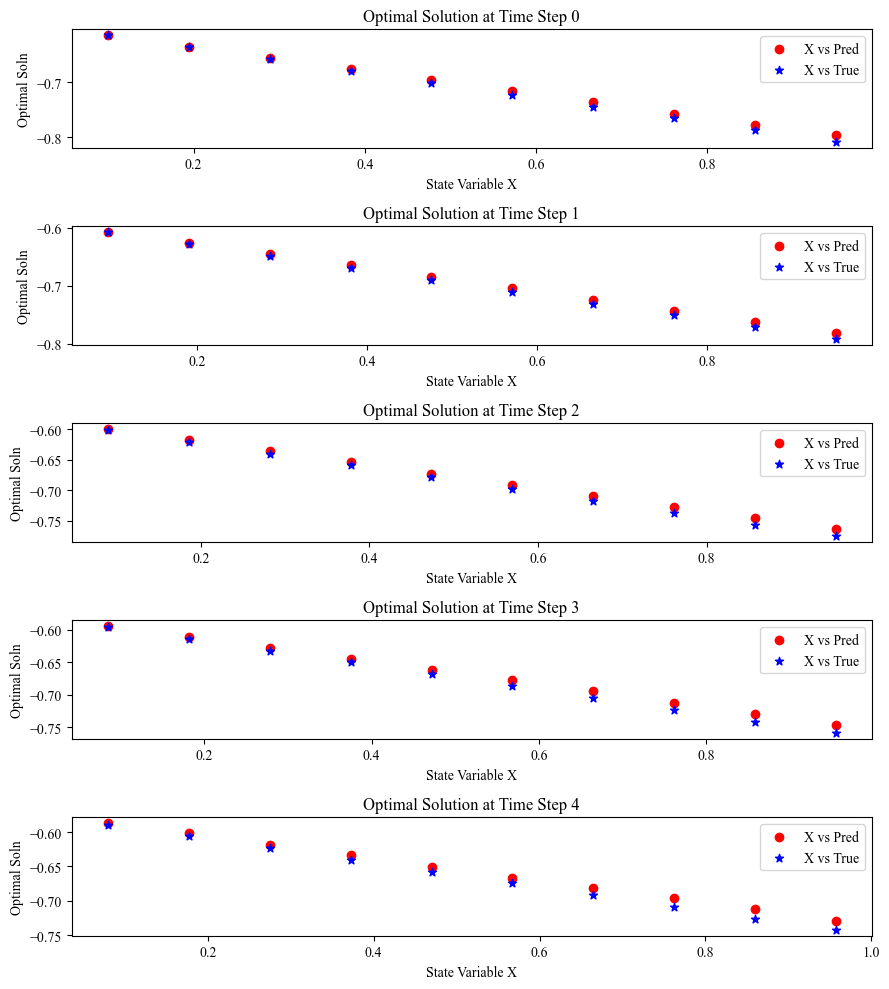

In [ ]:
import matplotlib.pyplot as plt
# Create subplots
fig, axs = plt.subplots(ite-5, 1, figsize=(9, 10))
state_var=state_var[:, :-1]
for i, ax in enumerate(axs):
    ax.scatter(state_var[:,i],pred[:,i],color='r',label='X vs Pred', marker='o')
    ax.scatter(state_var[:,i],u[:,i], color='blue', label='X vs True', marker='*')
    ax.set_xlabel('State Variable X')
    ax.set_ylabel('Optimal Soln')
    ax.set_title(f'Optimal Solution at Time Step {i}')
    ax.legend()
# Adjust layout
plt.tight_layout()
plt.show()

# Optimal solution for different sample path

In [100]:
matplotlib.use('Qt5Agg')
#fig, axs = plt.subplots(M1,1, figsize=(6, 25))
fig, axs = plt.subplots(10,1)

# Plot x vs y and x vs z on each subplot
for i, ax in enumerate(axs):
    ax.plot(t_eval,pred[i], color='b', label='Predicted')
    ax.plot(t_eval,u[i], color='r', label='Closed Form')
    ax.set_xlabel('Time')
    ax.set_ylabel('Optimal Solution')
    ax.set_title(f'Optimal solution for the sample path of X_0 = {state_var[i,0]:.2f}')
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_62811/3249822086.py:15: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.



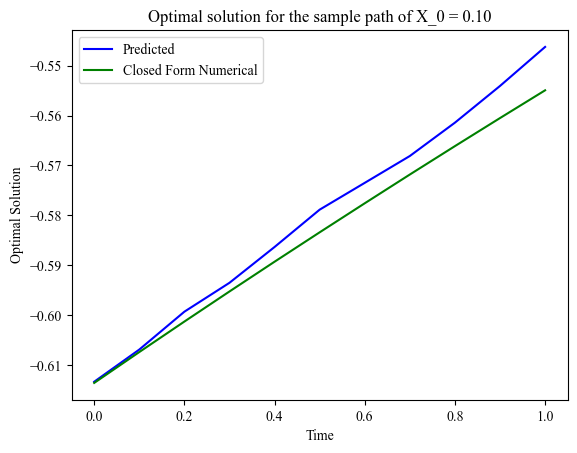

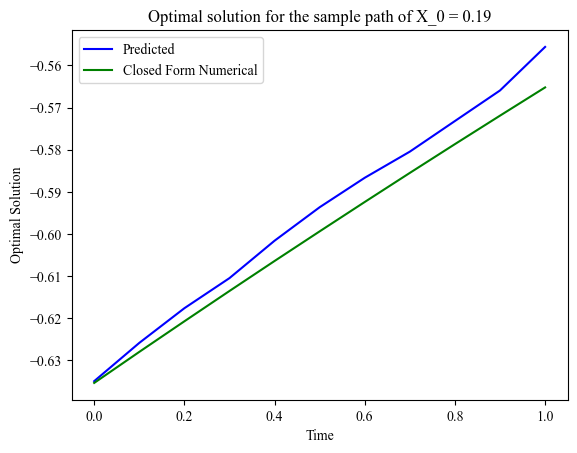

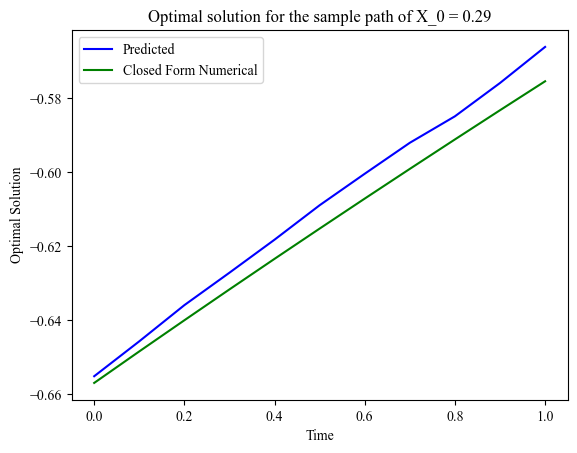

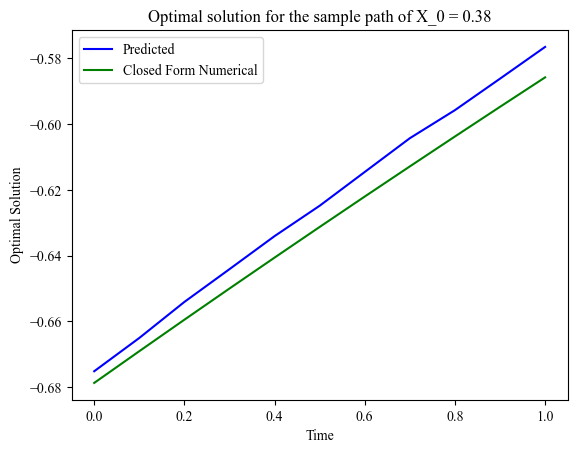

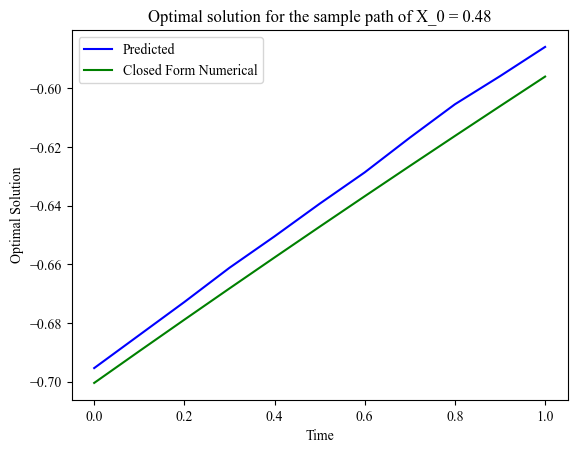

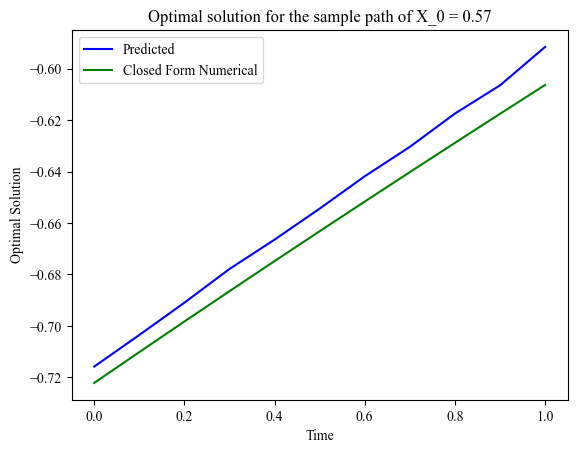

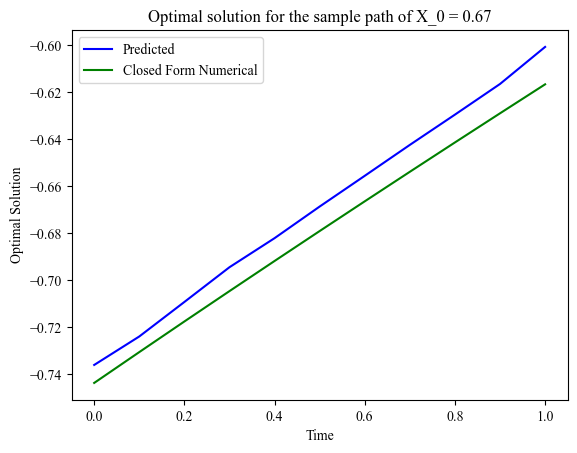

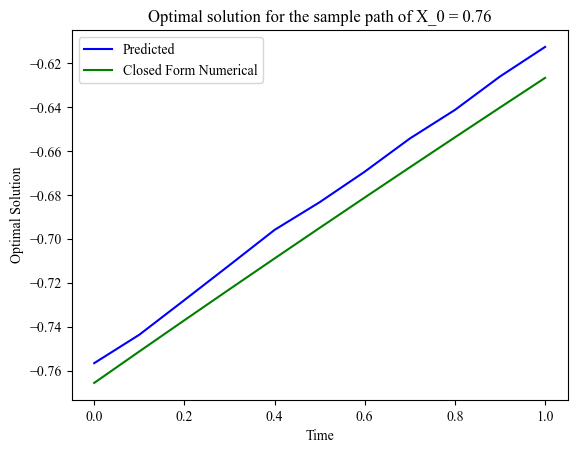

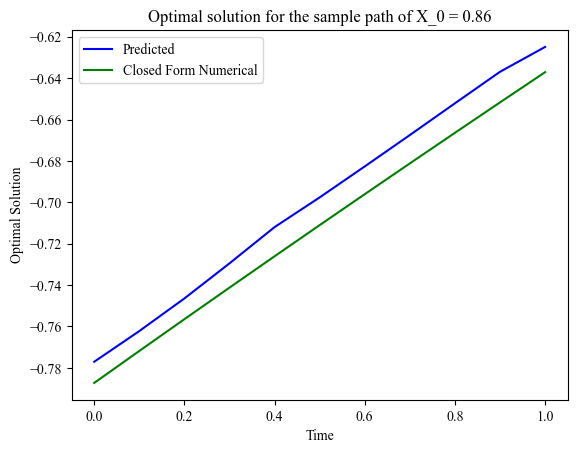

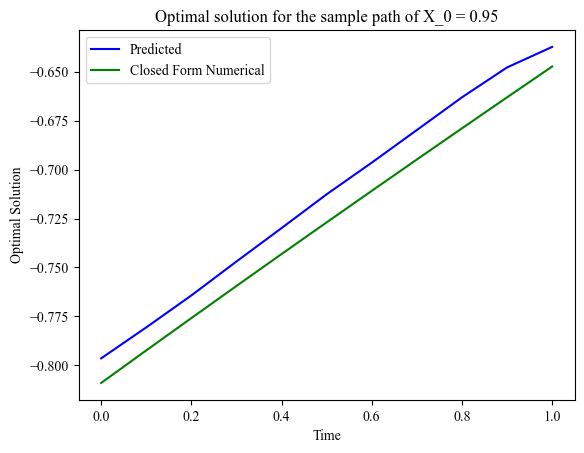

In [82]:
# Loop to create separate figures for each plot
for i in range(M1):  # Assuming you want two separate plots
    plt.figure()  # Create a new figure for each plot
    plt.plot(t_eval, pred[i], color='b', label='Predicted')
#     plt.plot(t_eval, u[i,:], color='r', label='Closed Form continuous')
    plt.plot(t_eval, u[i,:], color='g', label='Closed Form Numerical')
    
    plt.xlabel('Time')
    plt.ylabel('Optimal Solution')
    plt.title(f'Optimal solution for the sample path of X_0 = {state_var[i,0]:.2f}')
    plt.legend()
    
    # Show each plot separately
    plt.show()


In [101]:
import matplotlib.pyplot as plt

name = 'LQC_Brute_N100.eps'
x_0_values = state_var[:, 0]  # Assuming state_var[:, 0] holds your x_0 values for each i

plt.figure(figsize=(6, 3.8))
plt.rcParams['font.family'] = 'Times New Roman'

# Loop to plot each graph
for i in range(1, M1, 3):
    plt.plot(t_eval, pred[i, :], color='b', label='Predicted' if i == 1 else "")  # Show label only once
    plt.plot(t_eval, u[i, :], color='r', label='Closed Form' if i == 1 else "")  # Show label only once
    
    # Add x_0 value near each line
    plt.text(t_eval[-1], pred[i, -1], f'X_0= {x_0_values[i]:.2f}', color='black', fontsize=10, 
             ha='right', va='bottom')  # Label for predicted solution

# Set y-axis to log scale


# Axis labels, title, and legend
plt.xlabel('Time Steps', fontsize=9)
plt.ylabel('Optimal Solution', fontsize=9)
plt.title('Optimal Solution for Different Sample Path', fontsize=11)
plt.legend(fontsize=9, loc='upper left', bbox_to_anchor=(0, 1.0), borderpad=1, labelspacing=1.0, frameon=True)

# Save and display the plot
plt.savefig(name, format='eps')  # Reducing DPI to 100

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [84]:
print(state_var.shape)

(10, 11)


# Saving model and data

In [ ]:
# torch.save(model, 'model_N100_LQC_uniform_0_1_alpa0.1.pth')

state_var_train=np.squeeze(np.array(state_var_train))

# state_var_dic = {'state variable':state_var_train}

# np.savez('state_var_dic_N100_uniform_0_1_alpa0.1.npz',**state_var_dic)

cost_numpy_list = [tensor.detach().item() for tensor in cost_ar]
#state_var_train_list=[tensor.detach().tolist() for tensor in state_var_train]

# my_dic = {'Num_sample':M,'Time_step':ite,'T':T,'a':a,'b':b,'c':c,'d':d,'A':A,'B':B,
#           'alpa':alpa,'beta':beta,'Num_Neoron':neuron_model_psi,'Training_time':total_time,'epoch':max_epoch,
#            'accuracy':10,'Training loss':cost_numpy_list}

# file_path=  'N100_lqc_dic_uniform_0_1_alpa0.1.json'
# with open(file_path,'w') as file:
#     json.dump(my_dic,file)


: 

In [86]:
# import json
# cost_numpy_list = [tensor.detach().item() for tensor in cost_ar]
# #state_var_train_list=[tensor.detach().tolist() for tensor in state_var_train]

# my_dic = {'Num_sample':M,'Time_step':ite,'T':T,'a':a,'b':b,'c':c,'d':d,'A':A,'B':B,
#           'alpa':alpa,'beta':beta,'Num_Neoron':neuron_model_psi,'Training_time':total_time,'epoch':max_epoch,
#            'accuracy':10,'Training loss':cost_numpy_list}

# file_path=  'N10_lqc_dic_uniform_0_1.json'
# with open(file_path,'w') as file:
#     json.dump(my_dic,file)

In [87]:
import plotly.graph_objects as go

# Assuming x_train_np and y_train_np are your numpy arrays
# x_train_np[:, 0] -> X data
# x_train_np[:, 1] -> Y data
# y_train_np -> Z data

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=t_eval,  # X-axis data
    y=state_var[5],  # Y-axis data
    z=u[5],  # Z-axis data (adjust as needed for shape)
    mode='markers',      # Marker style
    marker=dict(
        size=5,          # Size of markers
        color=u[5],  # Color by Z-axis values
        colorscale='Viridis',  # Color scale
        opacity=0.8      # Opacity of the markers
    )
)])

# Update the layout for labels and title
fig.update_layout(
    title="Interactive 3D Scatter Plot On Training Sample",
    scene=dict(
        xaxis_title="Time",
        yaxis_title="State Variable x",
        zaxis_title="Optimal Solution"
    ),
    margin=dict(l=0, r=0, b=0, t=40)  # Tight layout
)

# Show the interactive plot
fig.show()

# Surface plot for the Optimal Solution

interactive(children=(IntSlider(value=30, description='elev', max=90, step=5), IntSlider(value=110, descriptio…

<function __main__.plot_3d_surface(elev=30, azim=110)>

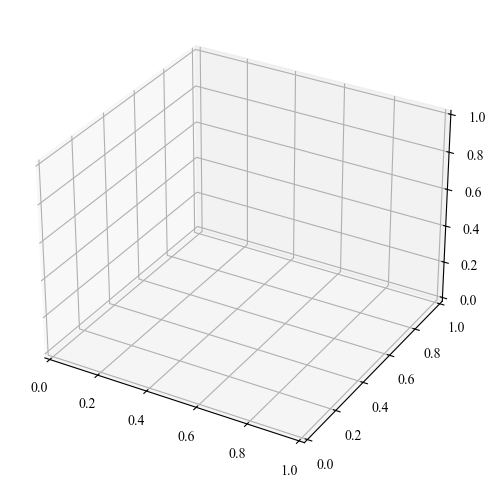

In [88]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact

X_0=5

# Create a grid of x and y values
x_grid, y_grid = np.meshgrid(state_var[X_0, :], t_eval)  # Adjust dimensions if needed
z1 = np.tile(u[X_0, :], (101, 1))
z2 = np.tile(pred[X_0, :], (101, 1))

# Function to create the plot
def plot_3d_surface(elev=30, azim=110):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot surfaces
    surf1 = ax.plot_surface(x_grid, y_grid, z1, cmap='viridis', alpha=0.8, label='Closed Form')
    surf2 = ax.plot_surface(x_grid, y_grid, z2, cmap='plasma', alpha=0.8, label='Predicted')
    
    # Set labels and title
    ax.set_xlabel('State Values')
    ax.set_ylabel('Time')
    ax.set_zlabel('Optimal Solution')
    ax.set_title('3D Surface Plot for Optimal Solution')

    # Adjust view angle
    ax.view_init(elev=elev, azim=azim)
    
    # Show plot
    plt.show()

# Interactive widget for angles
interact(plot_3d_surface, elev=(0, 90, 5), azim=(0, 360, 10))


In [89]:
print(state_var[X_0,:])

[0.57222223 0.570829   0.5694713  0.56828356 0.56721765 0.56625265
 0.5654239  0.564707   0.5640627  0.5634842  0.5630994 ]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (11, 11) and arg 2 with shape (101, 11).

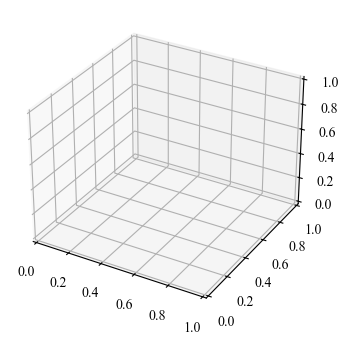

In [90]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D

# Create a grid of x and y values
x_grid, y_grid = np.meshgrid(state_var[X_0, :], t_eval)
z1 = np.tile(u[X_0, :], (101, 1))
z2 = np.tile(pred[X_0, :], (101, 1))

# Create a figure and a 3D axis
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# Plot the surfaces
surf1 = ax.plot_surface(x_grid, y_grid, z1, cmap='viridis', alpha=1.0)
surf2 = ax.plot_surface(x_grid, y_grid, z2, cmap='plasma', alpha=1.0)

# Add custom legend
legend_elements = [
    Line2D([0], [0], color='green', lw=4, label='Closed Form'),  # Match 'viridis' color
    Line2D([0], [0], color='orange', lw=4, label='Predicted'),   # Match 'plasma' color
]
ax.legend(handles=legend_elements, loc='upper left')

# Format axes ticks to two decimal places
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('State X')
ax.set_zlabel('Optimal Soln')

# Adjust the view angle
ax.view_init(elev=30, azim=110)

# Save the plot
plt.savefig('LQC_Brute_N100_X_0_0.68.pdf', format='pdf')

# Show the plot
plt.show()


In [ ]:
# data = np.load('state_var_dic_N10.npz')

# # Accessing the arrays
# array1 = data['state variable']
# data.close()
# print(array1)

In [ ]:
# import json
# cost_numpy_list = [tensor.detach().item() for tensor in cost_ar]
# #state_var_train_list=[tensor.detach().tolist() for tensor in state_var_train]

# my_dic = {'Num_sample':M,'Time_step':ite,'T':T,'a':a,'b':b,'c':c,'d':d,'A':A,'B':B,
#           'alpa':alpa,'beta':beta,'Num_Neoron':neuron_model_psi,'Training_time':total_time,'epoch':max_epoch,
#            'accuracy':10,'Training loss':cost_numpy_list}

# file_path=  'N10_lqc_dic.json'
# with open(file_path,'w') as file:
#     json.dump(my_dic,file)
